# Protein Structure and Kinematics
In the last lab, we learned how to use PyMOL to investigate protein structures and create hypotheses on structure-function relationships. However, we saw how difficult it is to predict how a binding pocket should be built by hand. To address this, several computational methods have been developed to use computers to predict and design protein structure and function.

In this lab, we will learn how proteins can adopt different conformations and how these conformations are imperative to protein design. At the end of this tutorial, you will be familiar with: 
* Quantifying protein degrees of freedom
* Amino acid side chain rotamers and the Dunbrack Rotamer Library
* Protein backbone flexibility


## Rosetta: A quick introduction
These tutorials will make heavy use of the [Rosetta Macromolecular Modeling Suite](https://www.annualreviews.org/doi/full/10.1146/annurev.biochem.77.062906.171838) to demonstrate different protein design concepts. We wil do a deep dive on the inner workings of Rosetta and the protein design algoithms implemented within, but first we will use Rosetta to demonstrate and visualize protein building blocks.

## Starting the PyMOLMover
Navigate to where you've installed PyRosetta on your computer and find the file called `PyMOL-RosettaServer.py`. The path should be `<Base path>/PyRosetta/src/PyMOL-RosettaServer.py`. Open up PyMOL and enter the command `run path/to/PyMOL-RosettaServer.py`. This will open a connection between Rosetta and PyMOL so that they can communicate.

This is what it should look like:

<img src="Assets/Tutorial_2/RunPyMOLServer.png" width="600" align="center"/>


Once the connection is established, we can pass a protein structure to PyMOL through Rosetta.

To run the following code, select the cell by clicking on it then click the "Run" button in the top bar. Alternatively, you can use `Ctrl + Enter` to run code in a selected cell or `Shift + Enter` run code in the selected cell and automatically move on to the next cell.

In [2]:
# Package and Module imports
import gzip
import os

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('seaborn-white')

import pyrosetta
import pyrosetta.rosetta as rosetta
from pyrosetta import toolbox

from ipywidgets import interact, interactive, fixed, interact_manual, HBox, Label
import ipywidgets as widgets
from IPython.display import display

# PyRosetta init
pyrosetta.init('-ex1 -ex2 -extrachi_cutoff 0 -mute all')
sfxn = rosetta.core.scoring.get_score_function()
pymover = rosetta.protocols.moves.PyMOLMover()

# Widget init
output = widgets.Output()

PyRosetta-4 2019 [Rosetta PyRosetta4.Release.python36.ubuntu 2019.22+release.d8f9b4a90a8f2caa32948bacdb6e551591facd5f 2019-05-30T13:47:16] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


# Degrees of Freedom in Proteins are Torsion Angles

[Torsion angles](https://en.wikipedia.org/wiki/Dihedral_angle) are the degrees of freedom that protein engineers use to quantify protein conformations. In short, the angle formed by two atoms when looking down the axis of rotatable bond is a torsion angle. For each residue in a protein, we can use torsion angles to describe a unique backbone and side chain conformation. 

### Each residue in a protein backbone possess three unique torsional degrees of freedom: 

1. $\phi$, Phi Angle: formed by the [C-N-C$\alpha$-C] backbone atoms 
2. $\psi$, Psi Angle: formed by the [N-C$\alpha$-C-N] backbone atoms
3. $\omega$, Omega angle: formed by the [C$\alpha$-C-N-C$\alpha$] backbone atoms

While there are three torsions we can measure, typically only two ($\phi$, Phi Angle and $\psi$, Psi Angle) are required to describe a unique conformation at a given position. This is because the $\omega$, Omega torsion angle is (for all intents and purposes) fixed at 180$^\circ$ due to the partial resonance and $sp_2$ character of the peptide bond.

### Amino acid side chains possess variable torsional degrees of freedom.

There are 18 side chains that possess torsional degrees of freedom (alanine and glycine lack an R-group with rotatable bonds). We will have a chance to explore these degrees of freedom in depth later in this lab.

# A Brief Review of Secondary Structure

Alpha helicies, beta sheets, and loops are the archetypal protein secondary structures. As protein engineers, we have become pretty good at using these building blocks to build increasingly large and complex proteins. Read this review, [The Coming of Age of De Novo Protein Design](https://www.ncbi.nlm.nih.gov/pubmed/27629638), to get a taste of the diversity of proteins we can engineer using just these three components. The following interactive labs will demonstrate why alpha helices and beta sheets are the core building blocks of proteins and why nature forces proteins to adopt these conformations.

### Why Ramachandran Plots?

You may have encountered the Ramachandran plot before and recall that it depicts "acceptable" $\phi$/$\psi$ angles in a protein structure. Instead of trying to make sense of a plot, let's deduce what it is trying to tell us by playing with a protein backbone and one simple fact: **secondary structure exists to minimize unsatisfied hydrogen bond donors/acceptors** ([here's one opinion on this topic](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2253345/)). Each peptide bond in a protein backbone contains a carbonyl group (hydrogen bond acceptor) and a amine group (hydrogen bond donor), and having an unsatisfied donor/acceptor in the protein core is highly unfavorable. A good hydrgen bond is 1.5-2 angstroms between the donor hydrogen and acceptor atom. 

Let's experiment with a long protein backbone to see how we can create structures composed of repeating $\phi$/$\psi$ angles that maximize backbone hydrogen bonding. Think about a backbone can interact with itself to maximize hydrogen bonding, as well as interacting with other backbone elements.

Run the following cell to experiment with different $\phi$/$\psi$ values that fullfil the physical constraints of secondary structure.

In [3]:
# Visualize the Ramachandran plot
backbone = pyrosetta.pose_from_sequence('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
pymover.apply(backbone)

def set_phi(phi):
    for residue in range(1, backbone.size() + 1):
        backbone.set_phi(residue, phi)
    pymover.apply(backbone)
    
def set_psi(psi):
    for residue in range(1, backbone.size() + 1):
        backbone.set_psi(residue, psi)
    pymover.apply(backbone)
    
phi_slider = widgets.IntSlider(min=-180, max=180, step=10, value=180)
psi_slider = widgets.IntSlider(min=-180, max=180, step=10, value=180)

display(interactive(set_phi, phi=phi_slider))
display(interactive(set_psi, psi=psi_slider))

interactive(children=(IntSlider(value=180, description='phi', max=180, min=-180, step=10), Output()), _dom_cla…

interactive(children=(IntSlider(value=180, description='psi', max=180, min=-180, step=10), Output()), _dom_cla…

The following ramachandran plot was generated using the [Top8000](http://kinemage.biochem.duke.edu/databases/top8000.php) dataset provided by the [Richardson Lab](http://kinemage.biochem.duke.edu) at Duke University. 

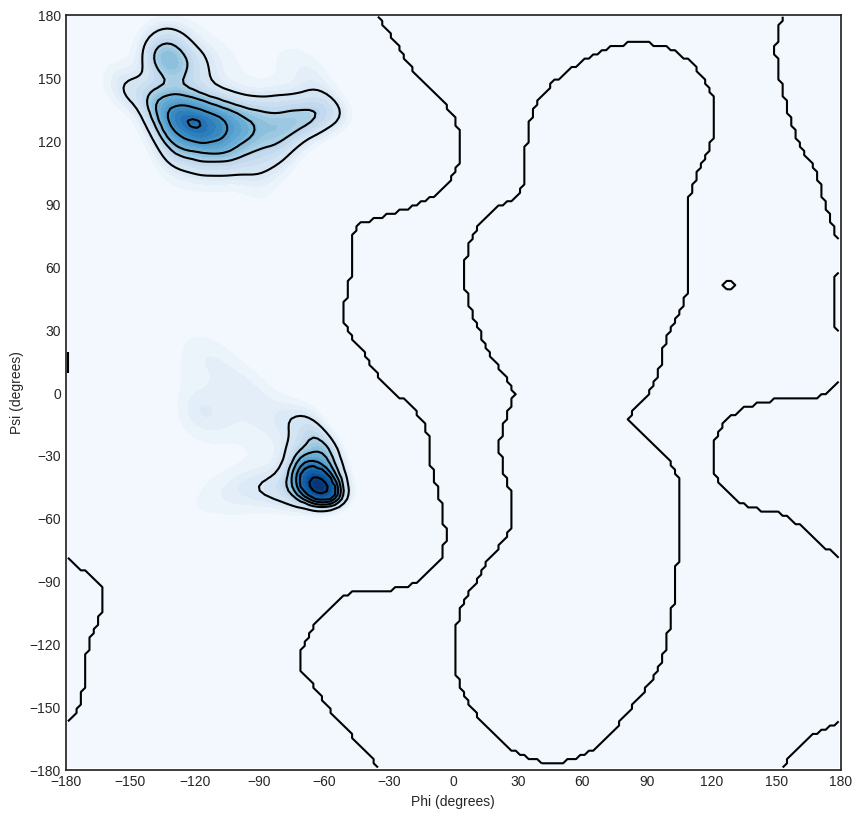

In [3]:
rama_df = pd.read_csv('Assets/Tutorial_2/rama8000-ileval-nopreP.zeroed.data', header=None)
X = Y = range(-179, 181, 2)
Z = np.asarray(rama_df[2]).reshape((180,180))

figure(figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
plt.contour(X, Y, Z, 8, colors='black')
plt.contourf(X, Y, Z, 25, cmap='Blues')

_ = plt.xticks(range(-180, 210, 30))
_ = plt.yticks(range(-180, 210, 30))
_ = plt.xlabel('Phi (degrees)')
_ = plt.ylabel('Psi (degrees)')

# Secondary Structures Possess Varied Geometries

We have explored using repeating $\phi$/$\psi$ elements to create regular secondary structures. However, you may have noticed that proteins do not resemble boxes assembled from straight alpha helices and flat beta sheets. By making regular variations to the "ideal" $\phi$/$\psi$ values, we can make secondary structures that maintain backbone hydrogen bonding while adopting various overall geometries.

Alpha helicies, for instance, can be described using parametric equations described by Grigoryan and DeGrado in their paper [Parameterization of Helical Bundles](https://doi.org/10.1016/j.jmb.2010.08.058). We won't concern ourselves with the exact equations here; the goal is to understand that we can use a set of equations with certain parameters to describe unique protein conformations.

Run the following cell to explore parameter space for different backbones. If you try to build a backbone and nothing happens, you most likely chose incompatible parameters. Try different parameters to see what types of structures you can create!

In [5]:
# Explore parameterized protein space

def create_bundle(_, **kwargs):
    
    make_bundle_xml = f'''
    <SCOREFXNS>
        <ScoreFunction name="sfxn" weights="ref2015"/>
    </SCOREFXNS>
    <MOVERS>
        <MakeBundle name="wiggle" helix_length="{length_slider.value}" crick_params_file="{crick_params.value}" symmetry="{symmetry_slider.value}" 
        r0="{r0_slider.value}"  omega0="{omega0_slider.value}" delta_omega0="{domega0_slider.value}" delta_omega1="{domega1_slider.value}"
        epsilon="{epsilon_slider.value}">
            <Helix/>
        </MakeBundle>
    </MOVERS>'''
    rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string(make_bundle_xml).get_mover("wiggle").apply(wiggle)
    pymover.apply(wiggle)

def dump_wiggle(_):
    wiggle.dump_pdb('ParametricallyDesignedProtein.pdb')

wiggle = rosetta.core.pose.Pose()

crick_params_options = ['alpha_helix', 'alpha_helix_100', 'beta_strand', 'neutral_beta_strand', 'L_alpha_helix']
crick_params = widgets.Dropdown(options=crick_params_options, value='alpha_helix')

length_slider = widgets.IntSlider(min=1, max=100, value=30)
symmetry_slider = widgets.IntSlider(min=1, max=12, value=1)
r0_slider = widgets.FloatSlider(min=1, max=30, step=0.1, value=10)
omega0_slider = widgets.FloatSlider(min=0, max=np.pi/4, step=np.pi/360, value=0)
domega0_slider = widgets.FloatSlider(min=0, max=np.pi, step=np.pi/36, value=0)
domega1_slider = widgets.FloatSlider(min=0, max=np.pi, step=np.pi/36, value=0)
epsilon_slider = widgets.FloatSlider(min=0, max=2, step=0.1, value=1)

run_button = widgets.Button(description='Build Backbone')
dump_pdb = widgets.Button(description='Generate PDB')

display(HBox([Label('Default Crick Parameters'), crick_params]))
display(HBox([Label('Symmetry'), symmetry_slider]))
display(HBox([Label('Length'), length_slider]))
display(HBox([Label('r0'), r0_slider]))
display(HBox([Label('omega0'), omega0_slider]))
display(HBox([Label('delta_omega0'), domega0_slider]))
display(HBox([Label('delta_omega1'), domega1_slider]))
display(HBox([Label('epsilon'), epsilon_slider]))
display(run_button)
display(dump_pdb)

run_button.on_click(create_bundle)
dump_pdb.on_click(dump_wiggle)

Button(description='Build Backbone', style=ButtonStyle())

Button(description='Generate PDB', style=ButtonStyle())

This demo only touches basic methods for generating secondary structures. Some things to explore:
* How would you use these parameters and equations to generate [beta-sheets](https://en.wikipedia.org/wiki/Beta_sheet)?
* How would you make perturbations to these regular structures (e.g. a bend/kink)?
* How would you combine alpha helices and beta sheets to create a protein from scratch?

# Protein Loops and Turns are... Complicated
We've explored why regular secondary structures are important for protein stability and how to generate them using simple parametric equations. However, you may have noticed in the previous example that the symmetric assemblies were not connected to each other; only alpha/beta structural elements were built. 

Protein loops and turns are the structural elements responsible for connecting regualr secondary structural elements. Loops and turns are irregular; where alpha helicies and beta sheets are composed of residues with repeating $\phi$/$\psi$ angles, loops and turns are quite varied. Due to their varied nature, protein loops and turns are difficult to model (remember, backbone hydrogen bond donors/acceptors still need to be satisfied!). 

Loop modeling is especially important since loops play a large part in protein funciton and conformational changes. Read this review: [Computational design of structured loops for new protein functions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6530579/)

In [ ]:
# todo: Generate loop ensemble to tab through...

# Backrub
# NextGenKIC
# CCD

# Protein Side-Chains Adopt Different Conformations
As we saw in the previous tutorial, amino acid side chains also adopt different conformations. These conformations vary depending on the backbone $\phi / \psi$ angles as well as the local environment of the side chain. First, let's explore how we can quantify different conformations for each naturally-occuring (canonical) amino acid.

In addition to backbone $\phi / \psi$ torsion angles, there are 18 amino acids with additional degress of freedom. Glycine and alanine are the two amino acids that lack these additional degrees of freedom since their R-groups lack rotatable bonds. However, all other amino acids possess one or more $\chi$ torsion angles. All $\chi$ angles for each canonical amino acid are defined [here](http://www.ccp14.ac.uk/ccp/web-mirrors/garlic/garlic/commands/dihedrals.html). 

Run the following cell and experiment with different $\chi$ angles for canonical amino acids.

In [6]:
# Visualize DOFs for different amino acids
interactive_rotamer = pyrosetta.pose_from_sequence('L')
pymover.apply(interactive_rotamer)

with output:
    def select_residue(resname):
        toolbox.mutate_residue(interactive_rotamer, 1, resname)
        pymover.apply(interactive_rotamer)
        
        # Get chi for current residue
        chi_dofs = interactive_rotamer.residue(1).chi()
        for chi_num, chi_dof in enumerate(chi_dofs, start=1):
            degree_slider = widgets.IntSlider(min=-180, max=180, step=10, value=chi_dof, description=fr'\(\chi_{chi_num}\)')
            display(interactive(alter_chi, chi=fixed(chi_num), degrees=degree_slider))

    def alter_chi(chi, degrees):
        interactive_rotamer.residue(1).set_chi(chi, degrees)
        pymover.apply(interactive_rotamer)
        
# Interactive bits
residue_selection = widgets.Dropdown( options=[res for res in 'CDEFHIKLMNQRSTVWY'], value='D', description='Residue:')
display(interactive(select_residue, resname=residue_selection))

interactive(children=(Dropdown(description='Residue:', index=1, options=('C', 'D', 'E', 'F', 'H', 'I', 'K', 'L…

You may have observed that many $\chi$ angle combinations produce obviously unfavorable conformations where the side chain makes steric clashes with itself. Indeed, this is what is observed in the PDB: amino acid side chains typically adpot certain conformations with large energy barriers between them. 

The [Dunbrack Rotatmer Library](https://doi.org/10.1016/j.str.2011.03.019) generated by the Roland Dunbrack Lab at the Fox Chase Cancer Center is a quantitative assessment of the different side chain conformations adopted by high-quality protein structures in the Protein Data Bank. These discrete side chain conformations, called **rotamers**, depend on backbone $\phi / \psi$ torsion angles. Rotamer probabilities are binned by major rotameric states, where the mean and standard deviation for each $\chi$ angle are provided for each 10$^\circ$ increment of $\phi$ and $\psi$.

Run the following cell to explore major rotameric states for canonical residues at different values of $\phi$ and $\psi$.

In [7]:
# Explore rotamers for a given phi/psi
bb_dependent_rotamer = pyrosetta.pose_from_sequence('GSG')
rotamer_df_dict = dict()
for rot in os.listdir('Assets/Rotamers/'):
    if rot.endswith('.bbdep.rotamers.lib.gz'):
        resname = rot[:3]
        residue_rotamers = gzip.open(f'Assets/Rotamers/{resname}.bbdep.rotamers.lib.gz')
        rotamer_df = pd.read_csv(residue_rotamers, comment='#', delim_whitespace=True, header=None).groupby([1,2])
        rotamer_df_dict[resname] = rotamer_df
        
with output:
    def set_phi(phi):
        bb_dependent_rotamer.set_phi(2, phi)
        toolbox.mutate_residue(bb_dependent_rotamer, 2, bb_dependent_rotamer.residue(2).name1())
        pymover.apply(bb_dependent_rotamer)

    def set_psi(psi):
        bb_dependent_rotamer.set_psi(2, psi)
        toolbox.mutate_residue(bb_dependent_rotamer, 2, bb_dependent_rotamer.residue(2).name1())
        pymover.apply(bb_dependent_rotamer)

    def display_residue(resname):
        toolbox.mutate_residue(bb_dependent_rotamer, 2, resname)
        pymover.apply(bb_dependent_rotamer)
    
    def current_rotamer():
        current_phi = round(bb_dependent_rotamer.phi(2))
        current_psi = round(bb_dependent_rotamer.psi(2))
        curent_resname = bb_dependent_rotamer.residue(2).name3().lower()
        current_rotamers_df = rotamer_df_dict[curent_resname].get_group((current_phi, current_psi))
        return curent_resname, current_rotamers_df
    
    def apply_rotamer(row):
        curent_resname, current_rotamers_df = current_rotamer()
        current_row = current_rotamers_df.iloc[row]
        for chi, i in enumerate(range(9, 13), start=1):
            if current_row[i] != 0:
                bb_dependent_rotamer.residue(2).set_chi(chi, current_row[i])
        print(f'Rotamer Probability: {current_row[8]}')
        pymover.apply(bb_dependent_rotamer)
    
    def update_rotamers(_):
        curent_resname, current_rotamers_df = current_rotamer()
        slider.options=range(0, len(current_rotamers_df))
        slider.value=0
        
# Widgets
slider = widgets.SelectionSlider(options=range(0, 1), description='Rotamer')
mutate_dropdown = widgets.Dropdown(options=[res for res in 'CDEFHIKLMNQRSTVWY'], value='S', description='Residue')
phi_slider = widgets.IntSlider(min=-180, max=180, step=10, value=180)
psi_slider = widgets.IntSlider(min=-180, max=180, step=10, value=180)

phi_slider.observe(update_rotamers)
psi_slider.observe(update_rotamers)
mutate_dropdown.observe(update_rotamers)

display(interactive(set_phi, phi=phi_slider))
display(interactive(set_psi, psi=psi_slider))
display(interactive(display_residue, resname=mutate_dropdown))
display(interactive(apply_rotamer, row=slider))

interactive(children=(IntSlider(value=180, description='phi', max=180, min=-180, step=10), Output()), _dom_cla…

interactive(children=(IntSlider(value=180, description='psi', max=180, min=-180, step=10), Output()), _dom_cla…

interactive(children=(Dropdown(description='Residue', index=12, options=('C', 'D', 'E', 'F', 'H', 'I', 'K', 'L…

interactive(children=(SelectionSlider(description='Rotamer', options=(0, 1, 2), value=0), Output()), _dom_clas…

# Short Protein Sequences Can Form Structural Motifs

todo: VALL/TERMS database of sequence<->structure relationships

# Introduction to the Protein Data Bank

todo: this.

# Deliverables

* Submit a PDB file of the parametrically designed protein backbone your created

# Additional Resources
* [Principles for Designing Protein Structures](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3705962/)
* [De novo design of a fluorescence-activating β-barrel](https://www.ncbi.nlm.nih.gov/pubmed/30209393)
* [De novo design of a four-fold symmetric TIM-barrel protein with atomic-level accuracy](https://www.ncbi.nlm.nih.gov/pubmed/26595462)